<function matplotlib.pyplot.show>

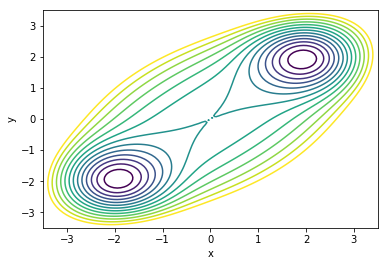

In [1]:
import numpy as np
import sys
import math
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

#TIS settings
n_moves = 500              # number of moves to perform for each path ensemble
op_type = 1                 # 1:x  2:y  3:x+y
interfaces = [-1.5, -1.4, -1.3, -1.2, -0.8, -0.5, 0.0, 1.0, 2.0]
basinA = -1.78              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000          # basin equilibration length (steps)
basinlen = 50000           # basin simulation length
shoot_weight = 0.5          # weight of shooting move
reversal_weight = 0.5       # weight of time reversal move
shoot_prob = shoot_weight/(shoot_weight + reversal_weight)
reversal_prob = reversal_weight/(shoot_weight + reversal_weight)

#Langevin dynamics settings
beta = 2.5     # 1/kT
gamma = 5.0    # friction coefficient
dt = 0.01      # time step size

#plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[i][j] = ld.potential(x_vec[i],y_vec[j])
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.xlabel('x')
plt.ylabel('y')
plt.show

Flux through first interface: 0.078

Number of first crossings: 39

Starting interface 0...
Starting interface 1...
Starting interface 2...
Starting interface 3...
Starting interface 4...
Starting interface 5...
Starting interface 6...
Starting interface 7...
Crossing probabilities: [0.438, 0.418, 0.464, 0.064, 0.318, 0.518, 0.488, 0.668]
Rate: 2.2771734608514745e-05


<function matplotlib.pyplot.show>

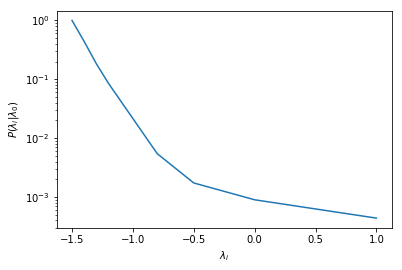

In [2]:
#declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)
#calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma)
#combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma)
#equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma)
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

basintraj[0] = basintrajeq
fromBasin = False
n_cross = 0
#run basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma)
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1])
    if op < basinA:
        fromBasin = True
    if fromBasin == True and op >= interfaces[0]:
        n_cross += 1
        fromBasin = False
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")
flux = n_cross/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
print("Number of first crossings: {}\n".format(n_cross))

#run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5
fromBasin = False
#use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma)
op = ld.calc_op(op_type,trajstep[0],trajstep[1])
while op < basinB:
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma)
    trajstep = nextstep
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
    if op < basinA:
        fromBasin = True
        initpath = []       # reset path if it returns to A
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue
    if op >= basinA and fromBasin == True:
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

# perform shooting and reversal moves for each interface
allpaths = []
cross_probs = []
for i in range(len(interfaces) - 1):
    print("Starting interface {}...".format(i))
    intpaths = []
    n_cross = 0
    path = np.asarray(initpath)
    for move in range(n_moves):
        if np.random.uniform() < shoot_prob:
            # find shooting point and perform shooting move
            index = np.where(path[:,6] >= interfaces[i])[0][0]
            # extract part of old path up to the shooting point
            partial_path = path[:index + 1]
            trajstep = ld.vv_step(partial_path[-1][:6],dt,beta,gamma)
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            trajstep = np.append(trajstep,[op],axis=0)
            partial_path = np.append(partial_path,[trajstep],axis=0)
            cross = False
            # perform forward time integration
            while op >= basinA and op < basinB:
                nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma)
                trajstep = nextstep
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                partial_path = np.append(partial_path,[trajstep],axis=0)
                if op >= interfaces[i+1]:
                    cross = True
            if cross == True:
                n_cross += 1
            intpaths.append(partial_path)
            path = partial_path
        else:
            # perform reversal and check for crossings and check path endpoints
            inB = False
            cross = False
            for step in path:
                if step[6] >= interfaces[i+1]:
                    cross = True
                if step[6] >= basinB:
                    inB = True
                    break
            if inB == False:
                path[:,2] *= -1
                path[:,3] *= -1
                intpaths.append(np.flip(path,axis=0))
                path = np.flip(path,axis=0)
                if cross == True:
                    n_cross += 1
            else:
                intpaths.append(path)
                if cross == True:
                    n_cross += 1
    allpaths.append(intpaths)
    cross_prob = n_cross/len(intpaths)
    cross_probs.append(cross_prob)

rate = flux*np.prod(np.asarray(cross_probs))
print("Crossing probabilities: {}".format(cross_probs))
print("Rate: {}".format(rate))

#plot cumulative crossing probability
cumuprob = []
for i in range(len(cross_probs)):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i])))
probs = plt.figure(2)
plt.plot(interfaces[:-1],cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda_i$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

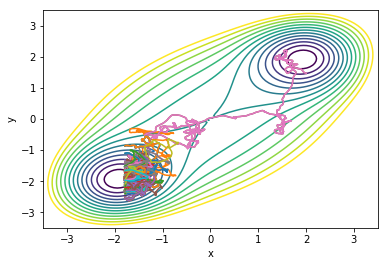

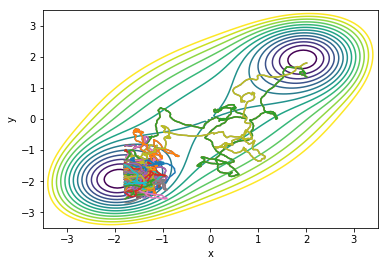

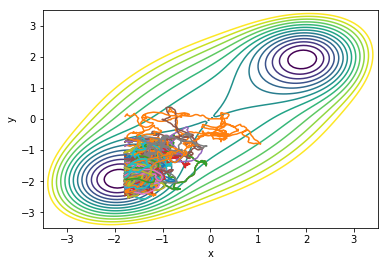

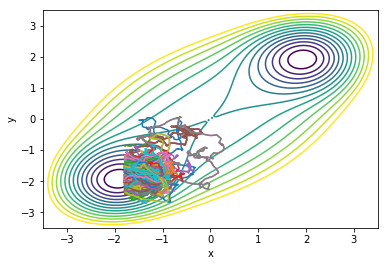

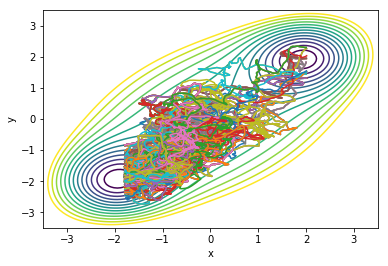

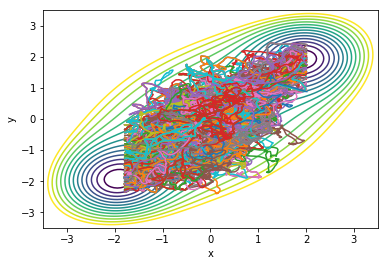

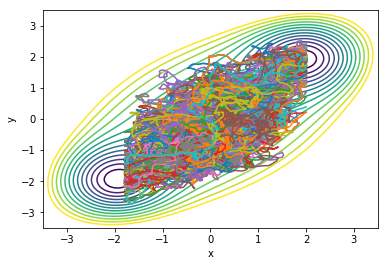

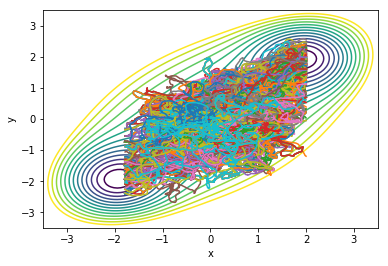

In [3]:
#plot sampled paths from each interface
for i in range(len(interfaces) - 1):
    plt.figure()
    for j in range(len(allpaths[i])):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1])
    plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show